This notebook compares the estimates of distance traveled obtained from GPS datasets with different temporal resolutions

In [190]:
# IMPORT PACKAGES
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Set default figure size
plt.rcParams['figure.figsize'] = [12, 10]  # [width, height] in inches

In [235]:
# IMPORT GPS DATA
gps_raw = pd.read_csv('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1.GPS.UTM.csv')

In [236]:
# Convert date and time from text to datetime obj
gps_raw['date_converted'] = pd.to_datetime(gps_raw['Date'], format='%d/%m/%Y', errors='coerce')
gps_raw['time_converted'] = pd.to_timedelta(gps_raw['Time'])
gps_raw['datetime'] = gps_raw['date_converted'] + gps_raw['time_converted']

# DEFINE START AND END TIMES

## 24 hr period
#start_time = '2019-02-26 00:00:00'
#end_time = '2019-02-27 00:00:00'

## Animal NOT moving
start_time = '2019-02-26 09:00:00'
end_time = '2019-02-26 10:00:00'

## Animal moving
# start_time = '2019-02-26 05:00:00'
# end_time = '2019-02-26 07:00:00'

## 10 min window during motion
# start_time = '2019-02-26 05:00:00'
# end_time = '2019-02-26 05:10:00'

## 10 min window during rest
# start_time = '2019-02-26 09:10:00'
# end_time = '2019-02-26 09:20:00'

# Filter dataframe for records between the start and end time
gps = gps_raw.copy()[(gps_raw['datetime'] >= start_time) & (gps_raw['datetime'] <= end_time)].reset_index()

In [237]:
# SUBSAMPLE THE GPS DATASETS
gps_1s = gps.copy()
gps_15s = gps.copy()[gps['datetime'].dt.second % 15 == 0]
gps_30s = gps.copy()[gps['datetime'].dt.second % 30 == 0]
gps_1m = gps.copy()[gps['datetime'].dt.second % 60 == 0]
gps_5m = gps.copy()[(gps['datetime'].dt.minute % 5 == 0)&(gps['datetime'].dt.second % 60 == 0)]
gps_10m = gps.copy()[(gps['datetime'].dt.minute % 10 == 0)&(gps['datetime'].dt.second % 60 == 0)]
gps_30m = gps.copy()[(gps['datetime'].dt.minute % 30 == 0) & (gps['datetime'].dt.second == 0)]
gps_1h = gps.copy()[(gps['datetime'].dt.minute % 60 == 0) & (gps['datetime'].dt.second == 0)]

In [238]:
# FUNCTION TO CALCULATE DISTANCE TRAVELED 

def dist_traveled(df):
    
    # Define start and end pts of each step
    x0 = df['UTM_E'].iloc[:-1].values
    x1 = df['UTM_E'].iloc[1:].values
    y0 = df['UTM_N'].iloc[:-1].values
    y1 = df['UTM_N'].iloc[1:].values
    
    # Calculate x1-x0 and y1-y0
    x_diff = x1-x0
    y_diff = y1-y0
    
    # Compute (x1-x0)^2 and (y1-y0)^2
    x_diff_sqr = x_diff*x_diff
    y_diff_sqr = y_diff*y_diff
    
    # Compute (x1-x0)^2 + (y1-y0)^2
    xy_diff_sqr_sum = x_diff_sqr + y_diff_sqr
    
    # Compute ((x1-x0)^2 + (y1-y0)^2)^0.5
    euclidean_distance_step = [math.sqrt(x) for x in xy_diff_sqr_sum]
    euclidean_distance_step = np.append([0],euclidean_distance_step)
    df['euclidean_distance_step'] = euclidean_distance_step

    # Compute total distance travel
    df['cum_dist'] = df['euclidean_distance_step'].cumsum()
    
    return df

In [239]:
# CALCULATE DISTANCE TRAVELED
dfs = [gps_1s,gps_15s,gps_30s,gps_1m,gps_5m,gps_10m,gps_30m,gps_1h]
labels = ['1s','15s', '30s', '1m', '5m','10m', '30m', '1h']  # Labels for each DataFrame
colors = ['blueviolet','tab:orange','tab:green','fuchsia','tab:red','paleturquoise','gold','black']
for df in dfs:
    df = dist_traveled(df)

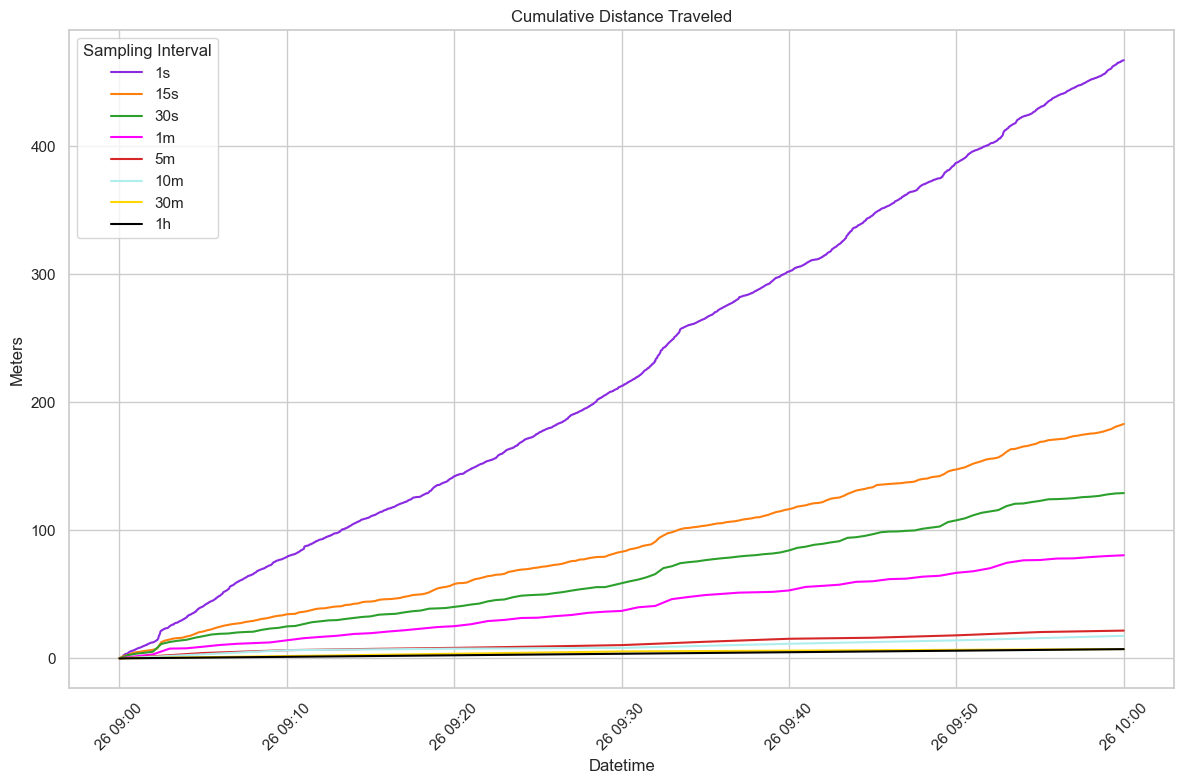

In [240]:
# Plot cumulative distance traveled as estimated from the GPS data

plt.figure(figsize=(12, 8))  # Set the figure size
sns.set_theme(style="whitegrid") # Set theme

for df, label, color in zip(dfs, labels,colors):
    sns.lineplot(data=df, x='datetime', y='cum_dist', label=label, color=color)

# Customize the plot
plt.title('Cumulative Distance Traveled')
plt.xlabel('Datetime')
plt.ylabel('Meters')
plt.legend(title='Sampling Interval')  # Add legend
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

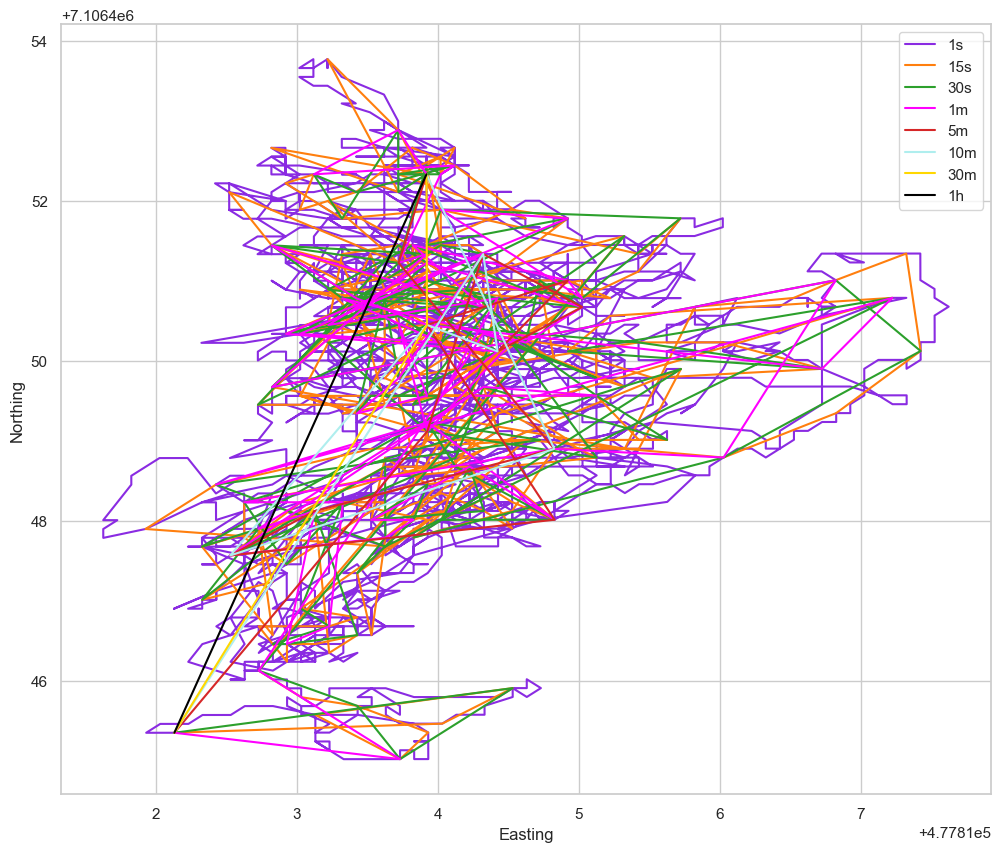

In [241]:
# PLOT GPS TRAJECTORY OF THE ANIMAL

# Initialize the plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(gps_1s['UTM_E'], gps_1s['UTM_N'],  color=colors[0], label = "1s")
ax.plot(gps_15s['UTM_E'], gps_15s['UTM_N'],  color=colors[1], label = "15s")
ax.plot(gps_30s['UTM_E'], gps_30s['UTM_N'],  color=colors[2], label = "30s")
ax.plot(gps_1m['UTM_E'], gps_1m['UTM_N'],  color=colors[3], label = "1m")
ax.plot(gps_5m['UTM_E'], gps_5m['UTM_N'],  color=colors[4], label = "5m")
ax.plot(gps_10m['UTM_E'], gps_10m['UTM_N'],  color=colors[5], label = "10m")
ax.plot(gps_30m['UTM_E'], gps_30m['UTM_N'],  color=colors[6], label = "30m")
ax.plot(gps_1h['UTM_E'], gps_1h['UTM_N'],  color=colors[7], label = "1h")


# Setting labels
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

# Adding a title and legend
ax.legend()

# Show plot
plt.show()

I belive that 5 minute is the best option, but could do 10 mins if we are concered about battery.
- When the animal is moving, 5min and 10 min resolution give a similar distance estimate to the finer resolution data
- When the animal is not moving, 5min and 10min resolution have low false distance accumulation
- 5 min trajectory when the animal is in motion looks more "natural" than the 10 min one 